In [1]:
%matplotlib inline

# Neuron receptor densities distribution

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

from matplotlib.colors import Normalize, ListedColormap, TwoSlopeNorm

## Loading data:

In [3]:
receptor_list = ['AMPA','NMDA','GABAa','GABAb','kainate','GABAa-BZ','M1','M2','M3','alpha4-beta2',
                 'alpha1','alpha2','5-HT1a','5-HT2','D1']
data = pd.read_excel('receptor-distribution-multitabs.xlsx', sheet_name=receptor_list, index_col=0, header=0)

# here is a conversion to be sure the region names are correctly formated
region = []
for i in data['AMPA'].index.values:
    region.append(str(i))
    
# layer depths
layer = ['supragranular', 'granular', 'infragranular']

# plot parameters
sample_alpha = 0.8
text_alpha=0.9
linewidth = 1
bins = 15

In [4]:
data['AMPA'].head()

,supragranular,SD,CV,granular,SD.1,CV.1,infragranular,SD.2,CV.2,all layers,SD.3,CV.3
Region,,,,,,,,,,,,
1,518,220,0.424,346.0,152.0,0.440,354,156,0.442,443,191,0.430
2,549,228,0.416,424.0,169.0,0.400,365,136,0.373,478,197,0.412
3a,564,164,0.291,389.0,110.0,0.281,334,93,0.279,473,145,0.306
3b,538,216,0.402,350.0,144.0,0.412,324,133,0.411,455,179,0.393
V1,606,344,0.567,406.0,169.0,0.415,276,121,0.439,496,274,0.412


## Ploting the AMPA distribution across brain region and by layer:

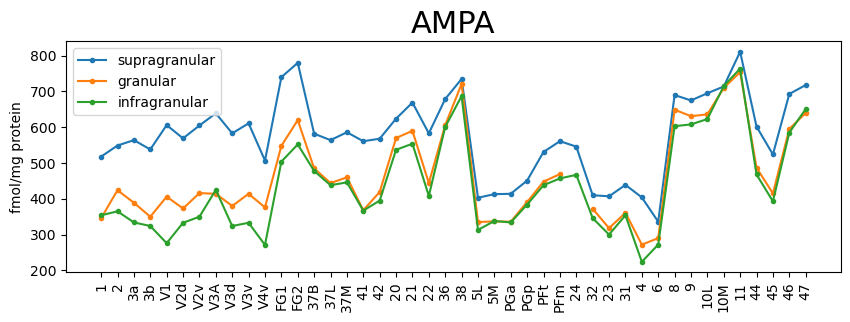

In [15]:
plt.figure(figsize=[10,3])
for l in layer:
    plt.plot(region, data[receptor_list[0]][l].values, label=l, marker= '.')
plt.legend()
plt.xticks(rotation = 90)
plt.ylabel('fmol/mg protein')
plt.title(receptor_list[0], fontsize=22);

## Ploting the NMDA distribution across brain region and by layer:

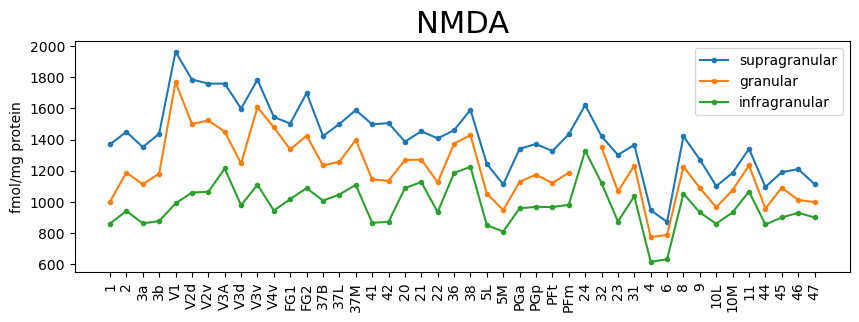

In [14]:
plt.figure(figsize=[10,3])
for l in layer:
    plt.plot(region, data[receptor_list[1]][l].values, label=l, marker= '.')
plt.legend()
plt.xticks(rotation = 90)
plt.ylabel('fmol/mg protein')
plt.title(receptor_list[1], fontsize=22);

In [7]:
# plt.figure(figsize=[20,6])
# for rec in receptor_list:
#     for l in layer:
#         plt.plot(region, data[rec][l].values, label=[rec,l])
# plt.legend()
# plt.xticks(rotation = 45)
# plt.ylabel('fmol/mg protein');

## NMDA/AMPA ratios accross regions

Text(0.5, 1.0, 'NMDA to AMPA ratio')

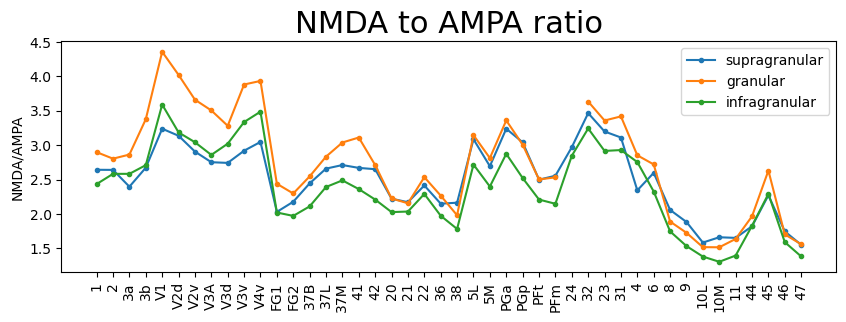

In [13]:
plt.figure(figsize=[10,3])
for l in layer:
    plt.plot(region, data[receptor_list[1]][l].values/data[receptor_list[0]][l].values, label=l, marker= '.')
plt.legend()
plt.xticks(rotation = 90)
plt.ylabel('NMDA/AMPA')
plt.title('NMDA to AMPA ratio', fontsize=22)

## Histogram of neuron receptors distribution across brain region and by layer:

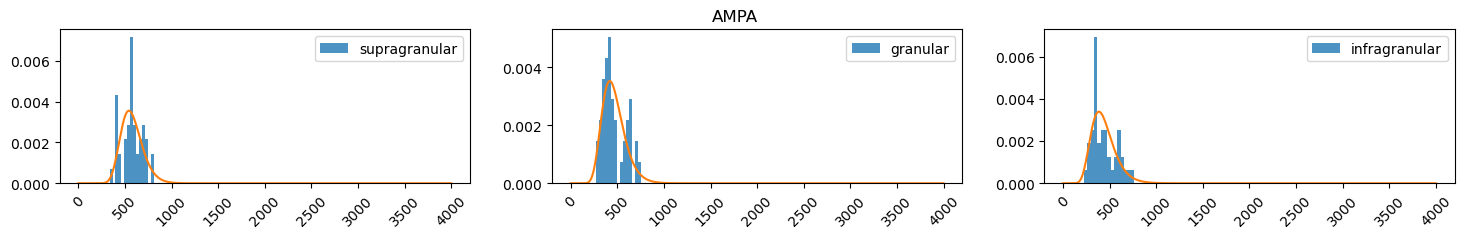

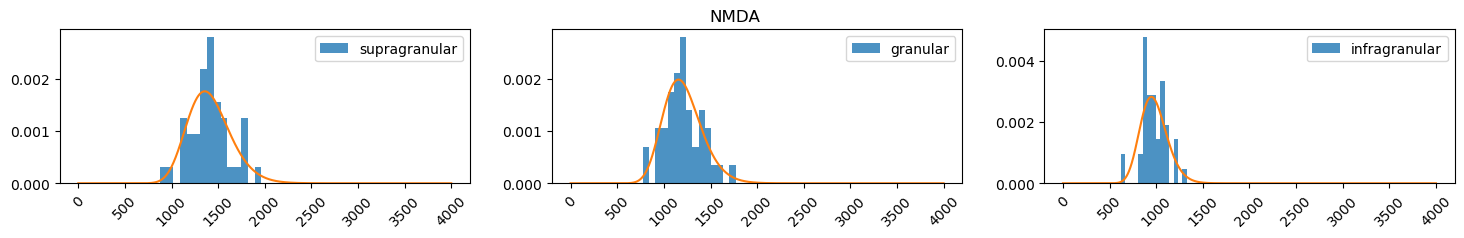

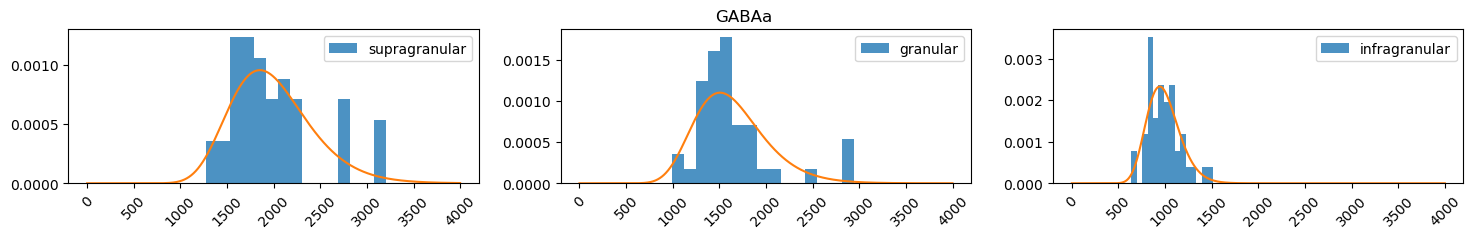

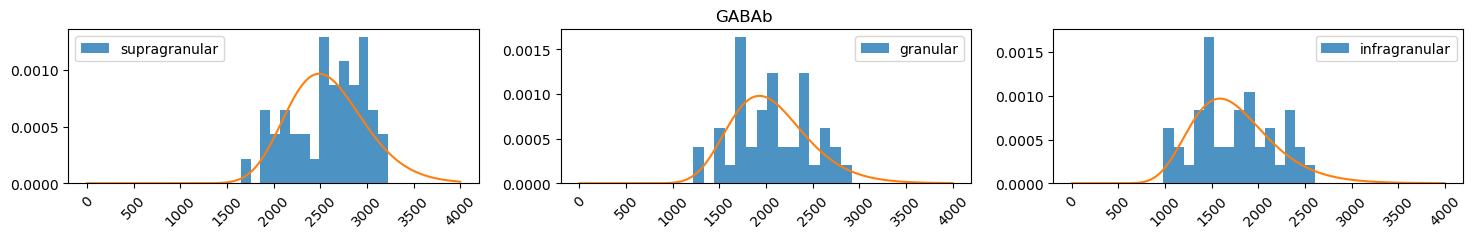

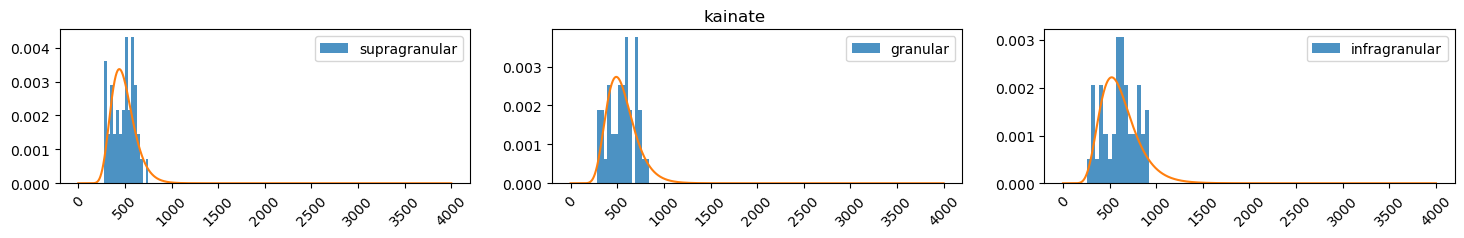

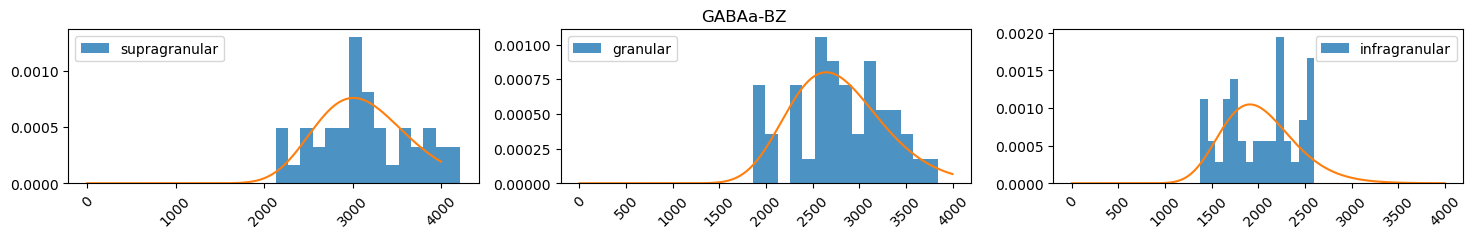

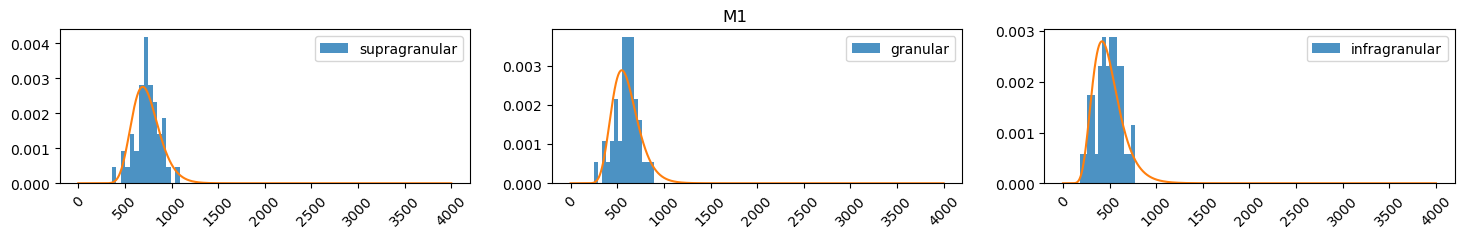

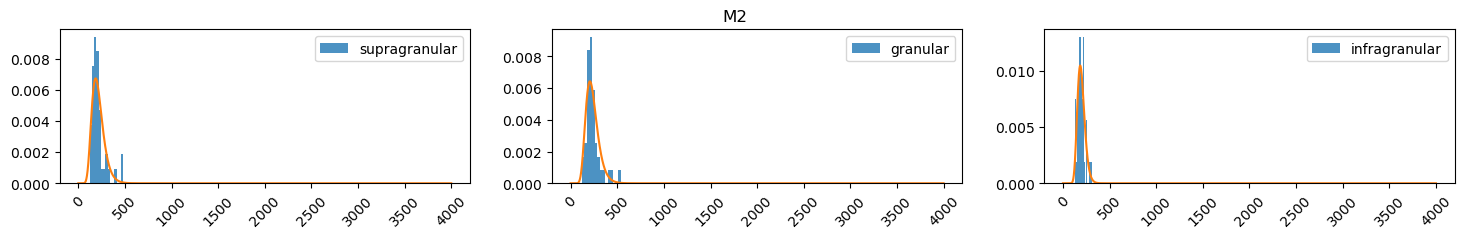

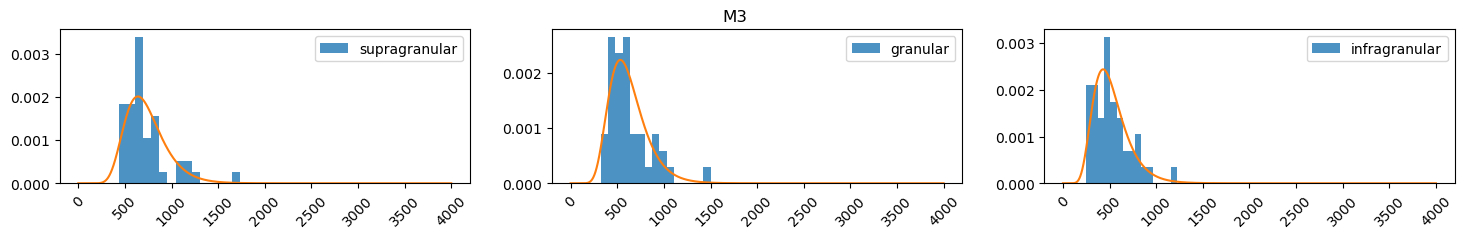

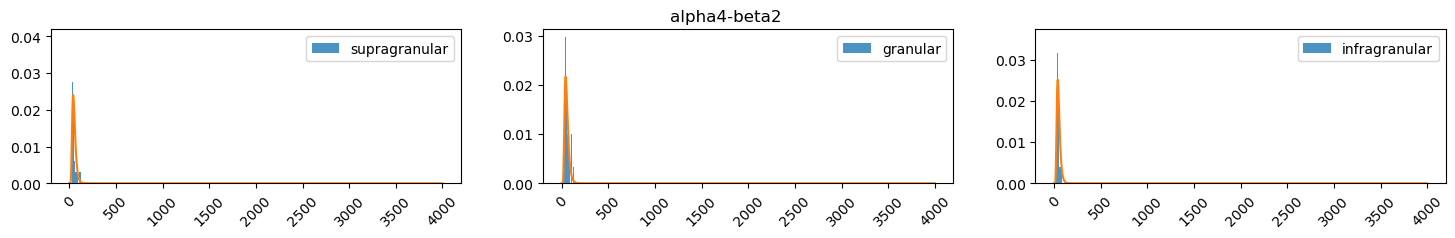

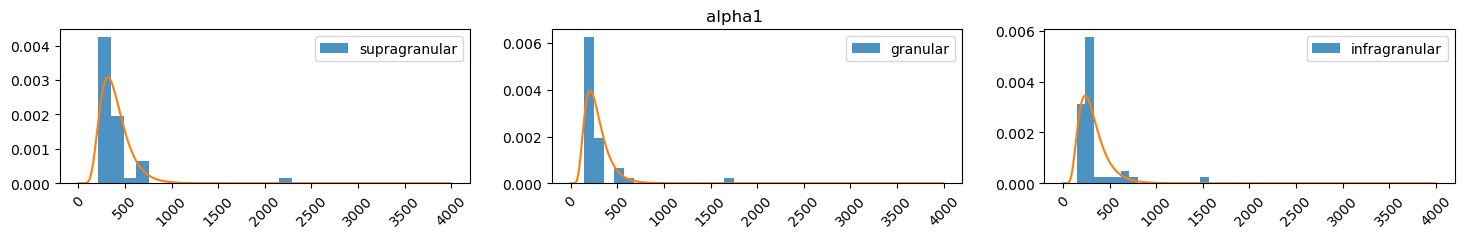

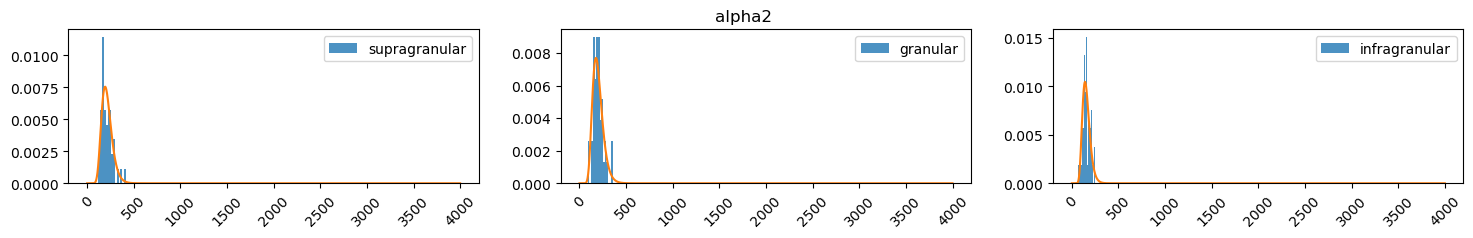

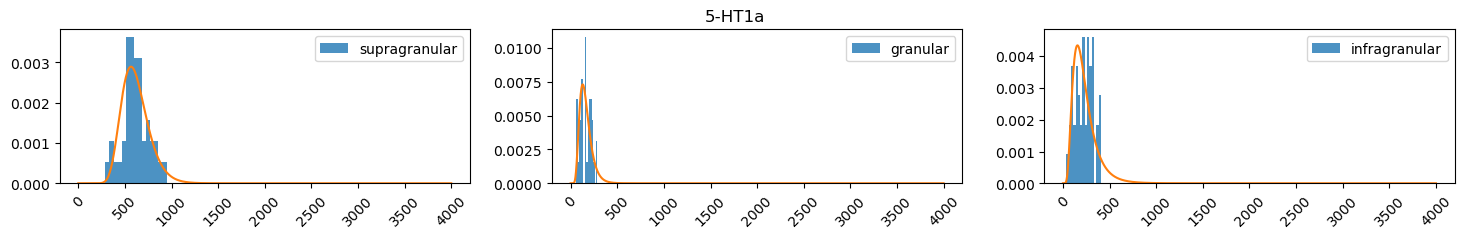

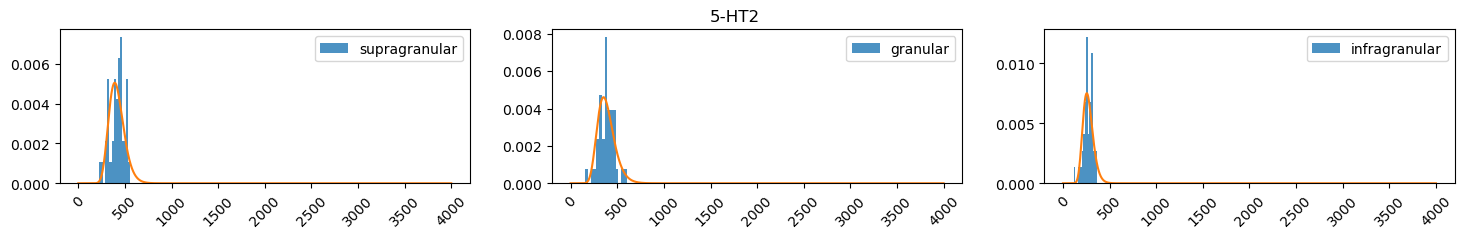

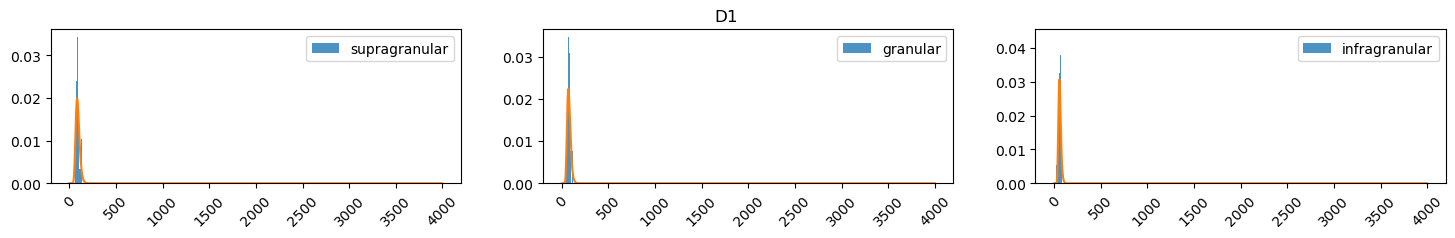

In [9]:
# Testing if the density is lognormally distributed

x = np.arange(0, 4000, step=1)
for rec in receptor_list:
    plt.figure(figsize=[18,2])
    aux = 0
    for l in layer:
        aux+=1
        plt.subplot(1,3,aux)
        plt.hist(data[rec][l].values, label=[l], density=True, bins=bins, alpha=sample_alpha)
        plt.legend()
        plt.xticks(rotation = 45);
        
        # Plot pdf
        plt.subplot(1,3,aux)
        logdata = np.log(data[rec][l].values)
        dist = stats.lognorm.pdf(x, s=np.nanstd(logdata), loc=0, 
                               scale=np.exp(np.nanmean(logdata)))
        plt.plot(x, dist)
    plt.suptitle(rec)

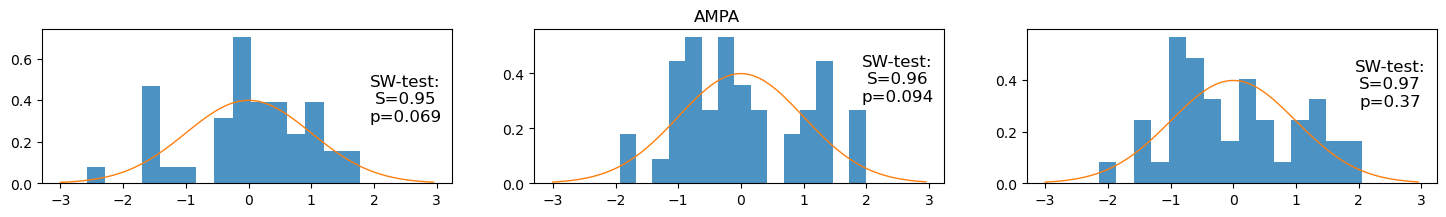

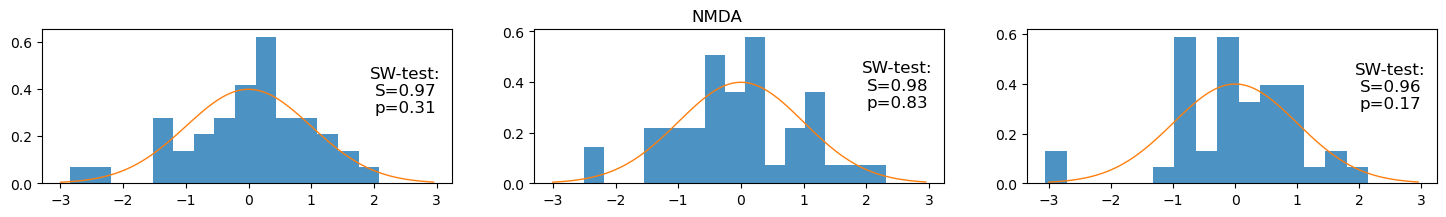

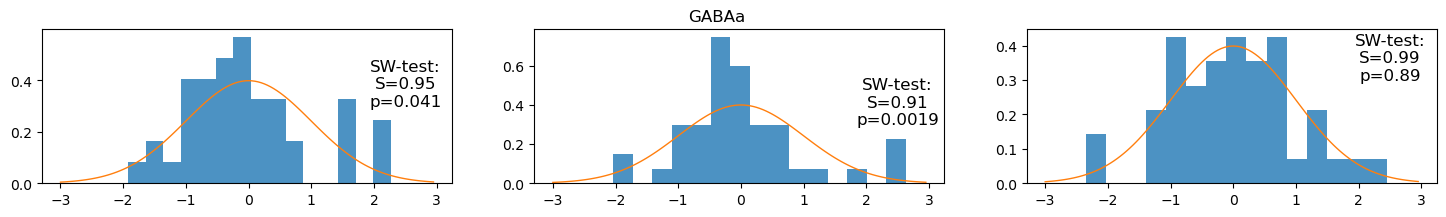

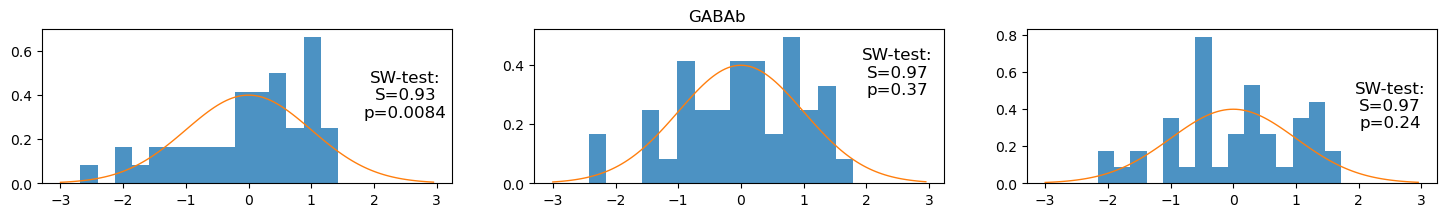

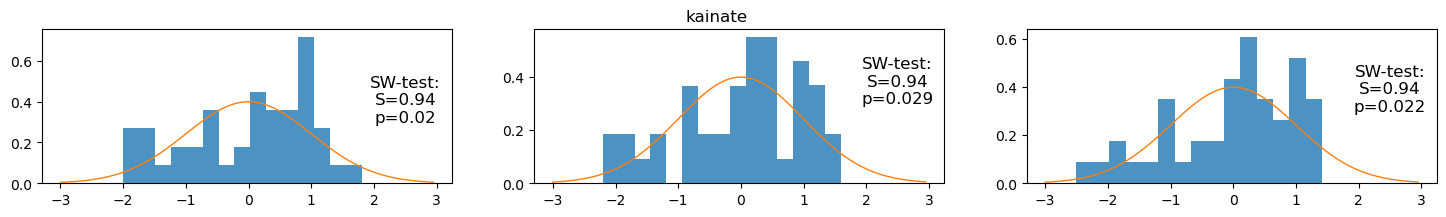

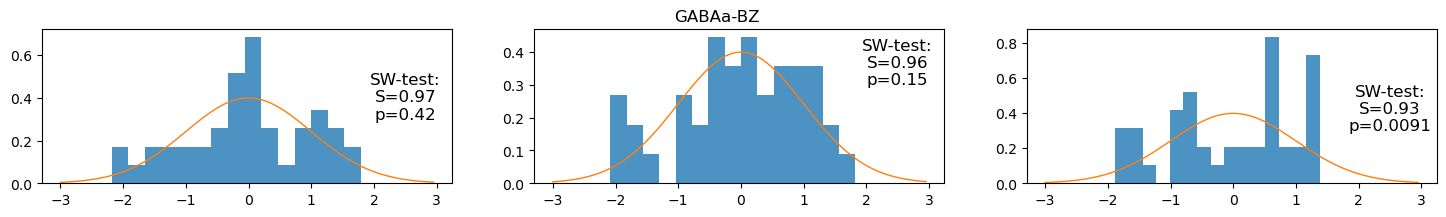

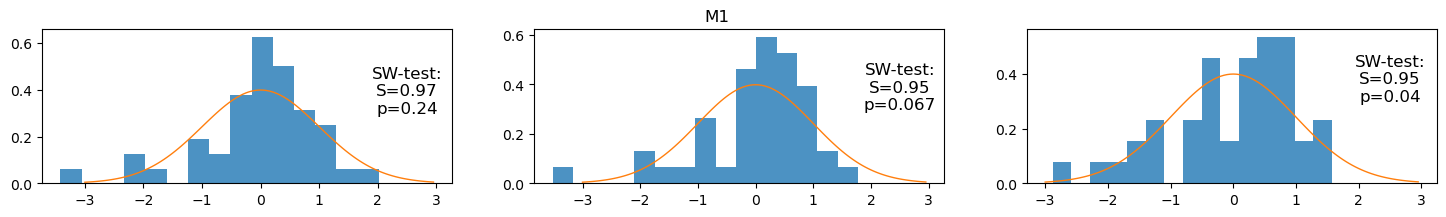

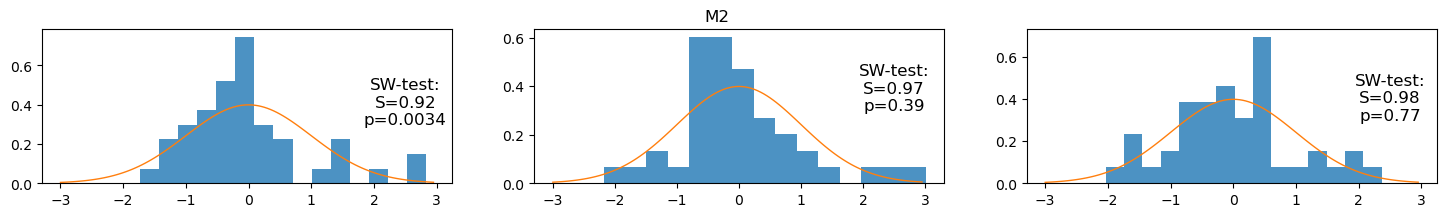

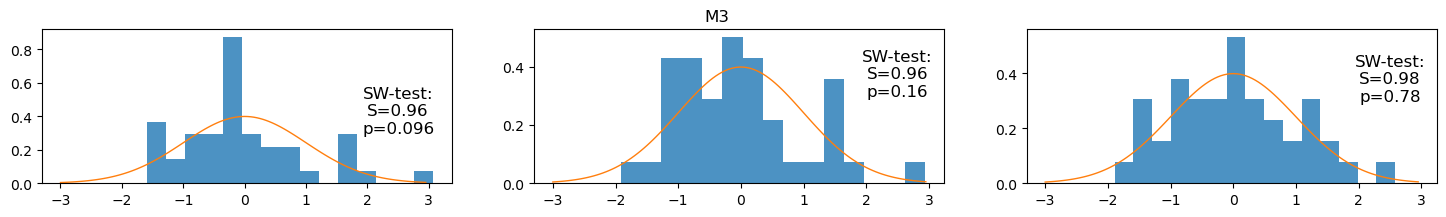

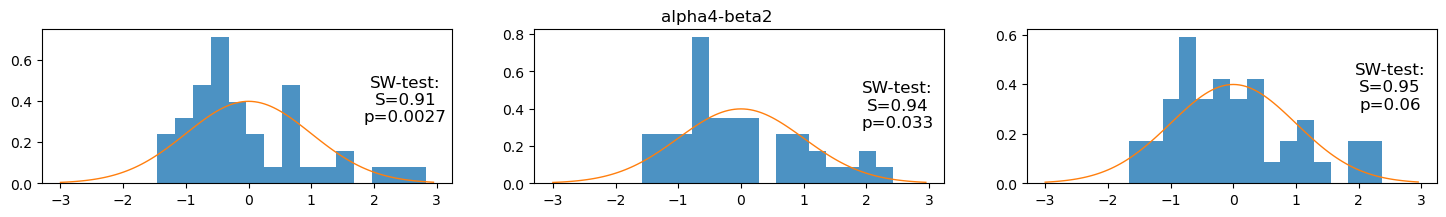

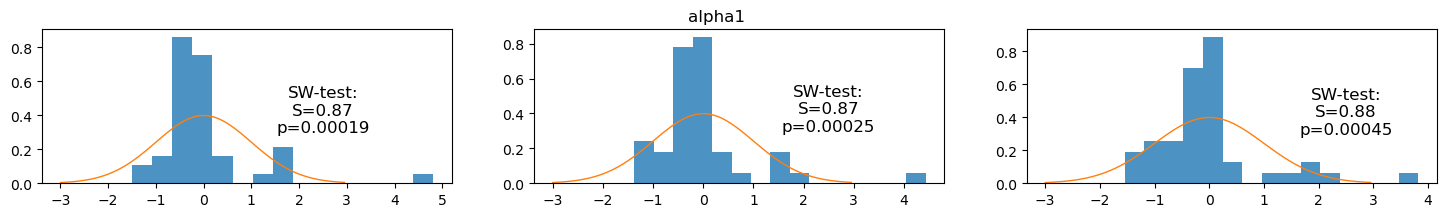

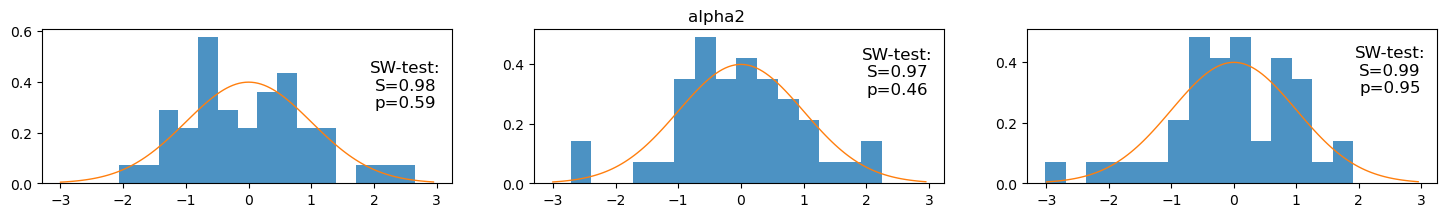

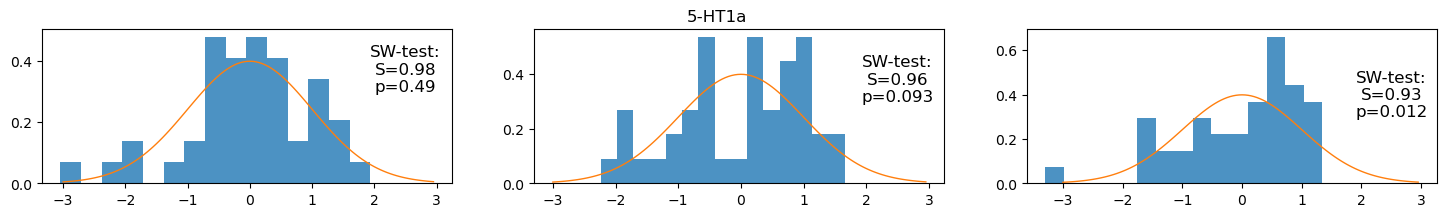

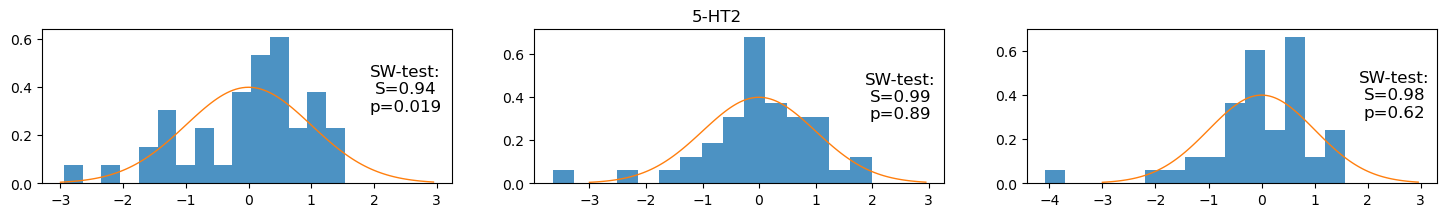

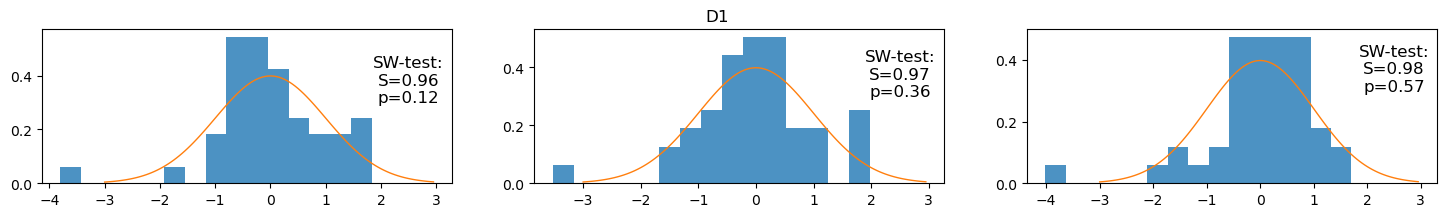

In [10]:
# Z-scored log of density

zs = []
x = np.arange(-3, 3, step=0.05)

for rec in receptor_list:
    plt.figure(figsize=[18,2])
    aux = 0
    for l in layer:
        aux+=1
        plt.subplot(1,3,aux)
        
        logdata = np.log(data[rec][l].values)
        z = (logdata - np.nanmean(logdata)) / np.nanstd(logdata)
        zs.append(z)
        # Plot histogram of data
        plt.hist(z, bins=bins, density=True, alpha=sample_alpha)
        
        dist = stats.norm.pdf(x, loc=0, scale=1)
        plt.plot(x, dist, label=l, lw=linewidth)
        
        # Testing
#         print(z[np.abs(z) >= 3])
        z = z[np.abs(z) < 3]
        S, p = stats.shapiro(z)
        plt.text(2.5, 0.3, f'SW-test:\nS={S:.2}\np={p:.2}', fontsize=12,
                ha='center')
        
#         plt.legend()
    plt.suptitle(rec)

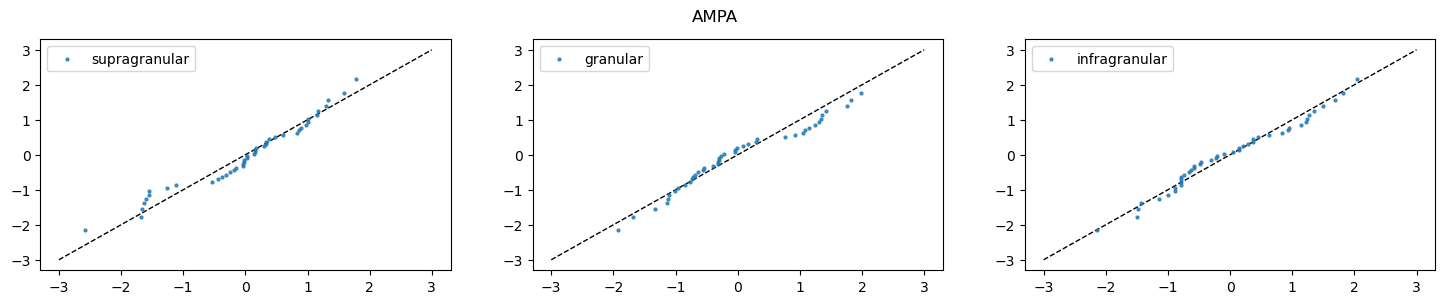

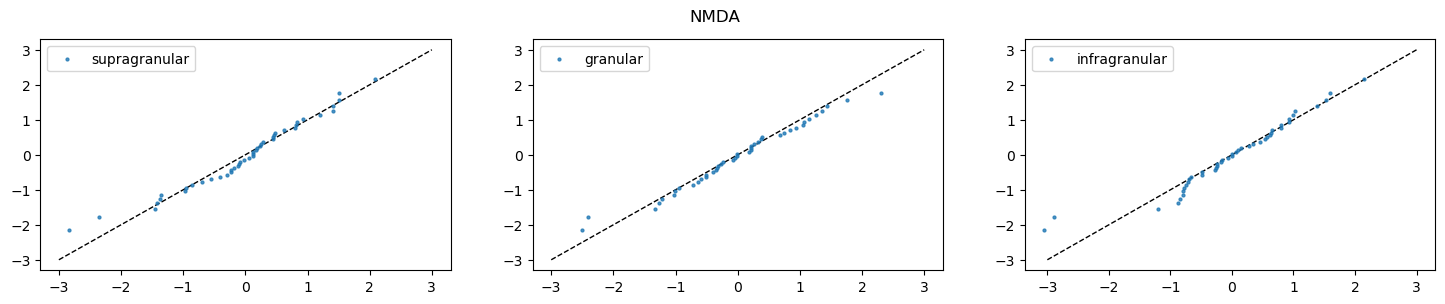

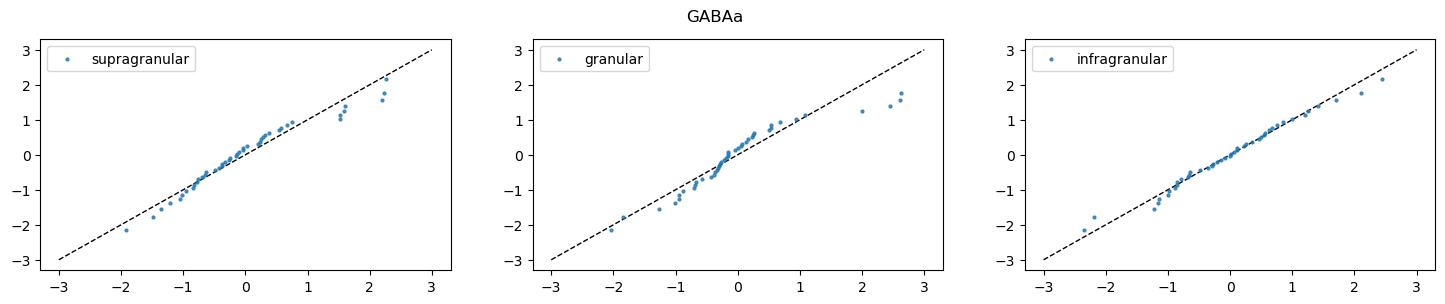

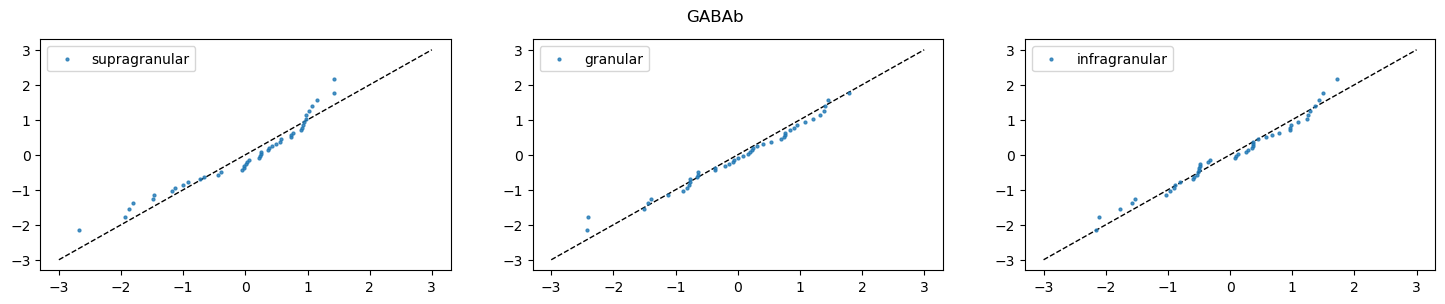

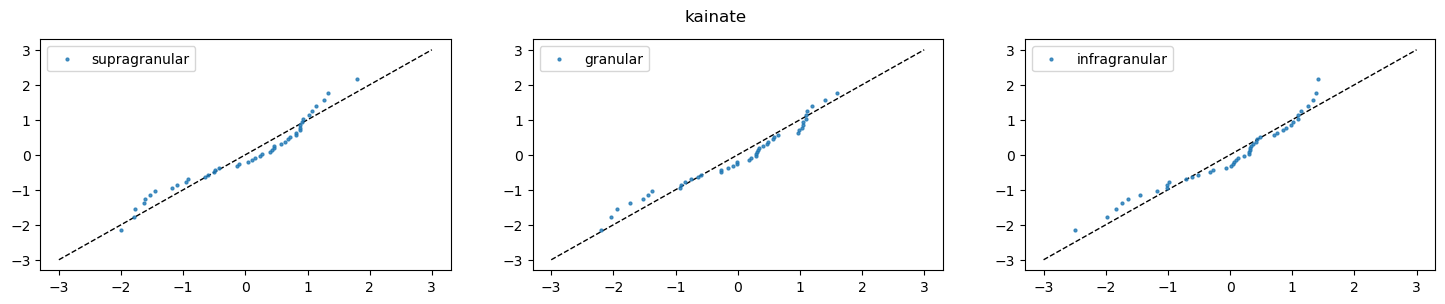

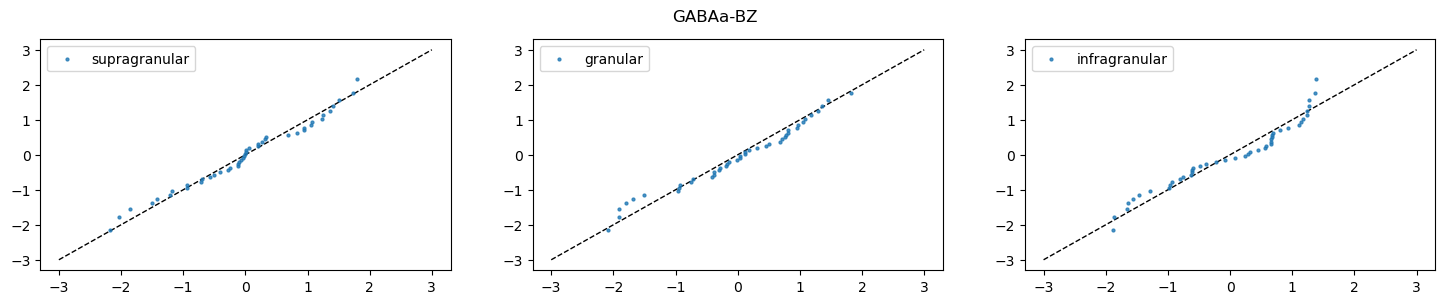

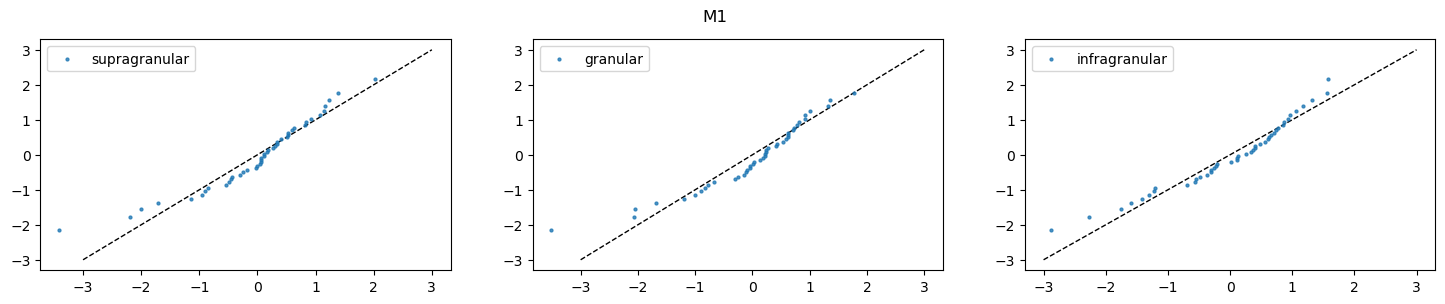

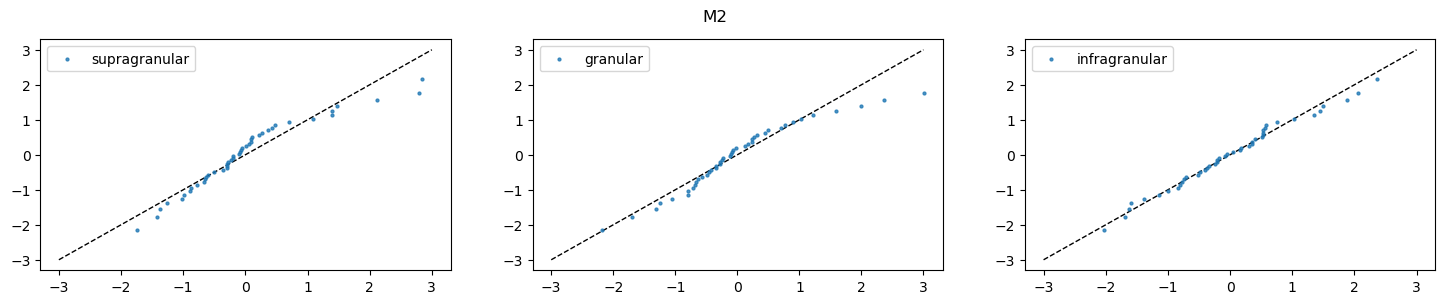

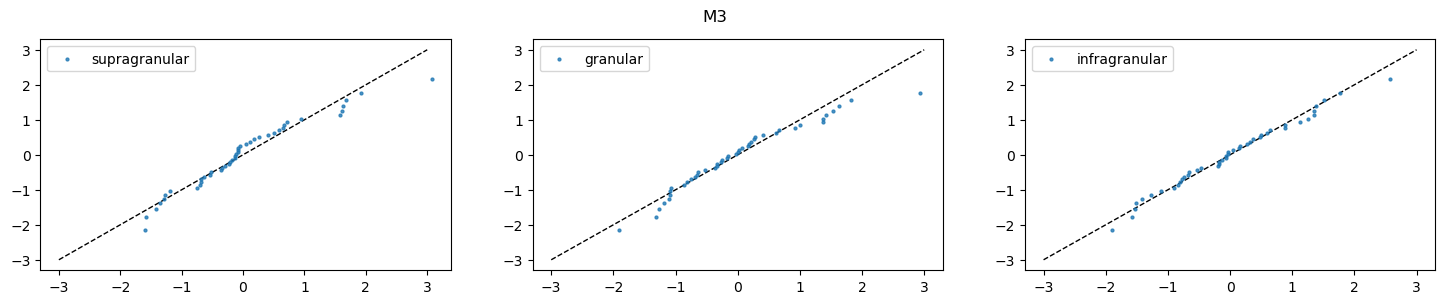

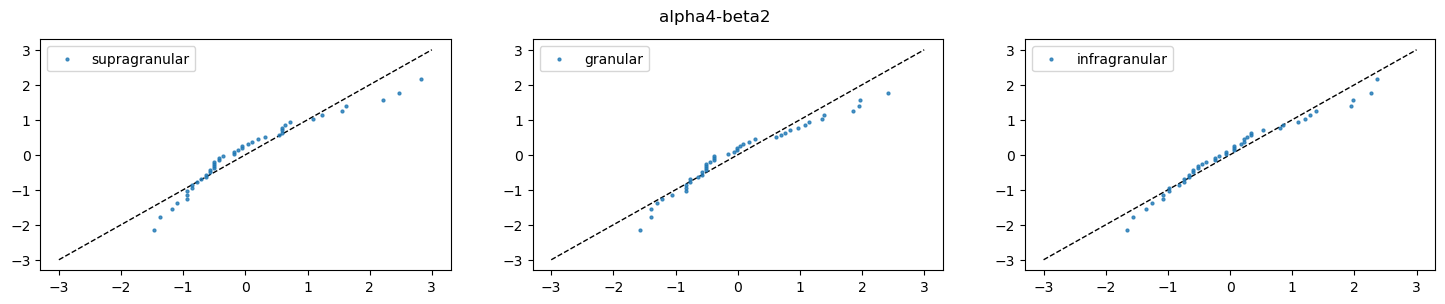

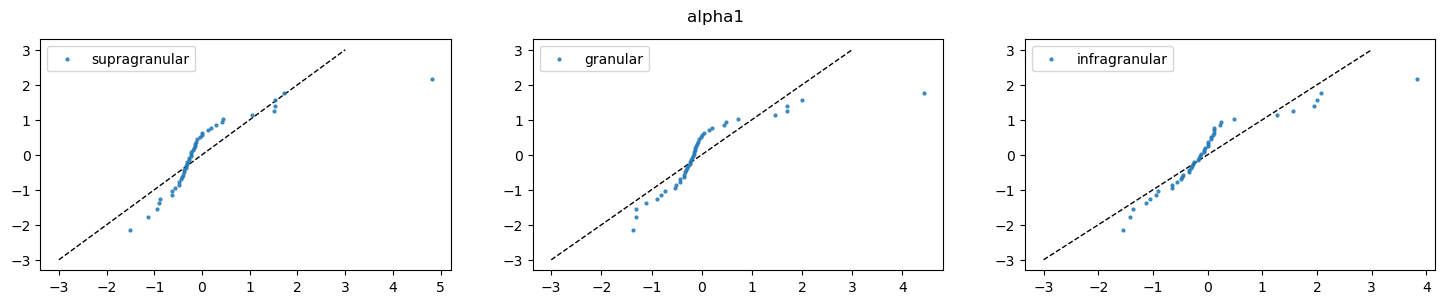

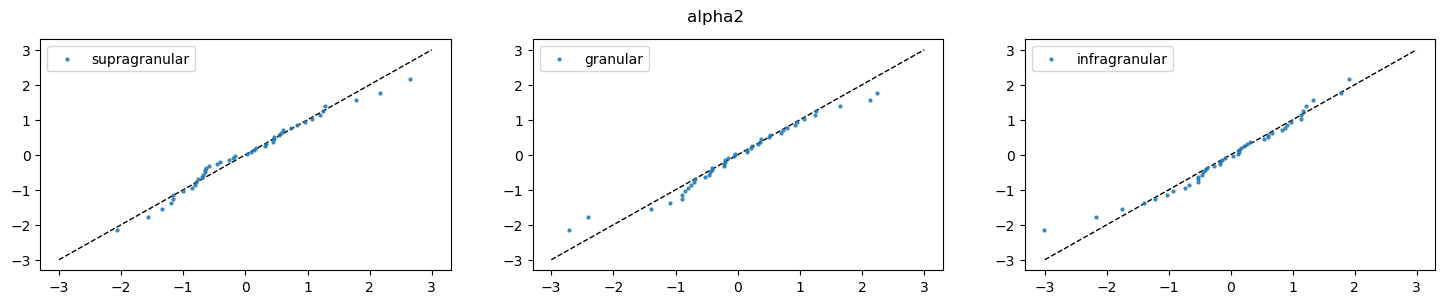

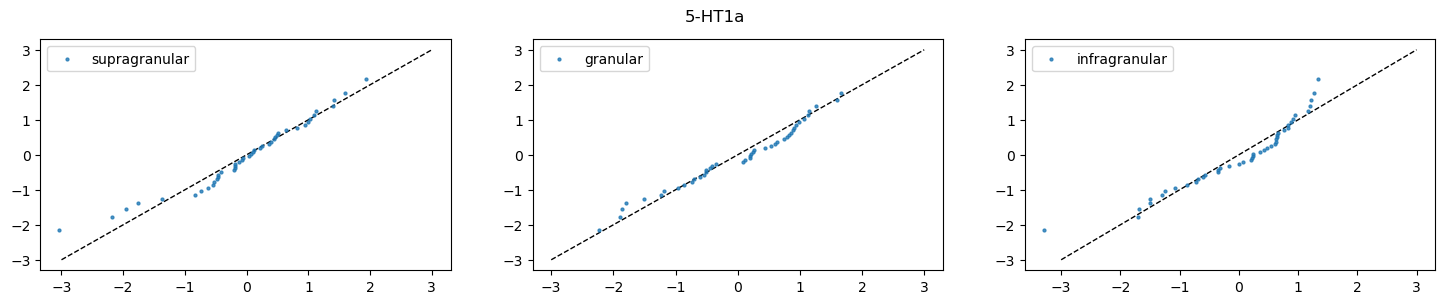

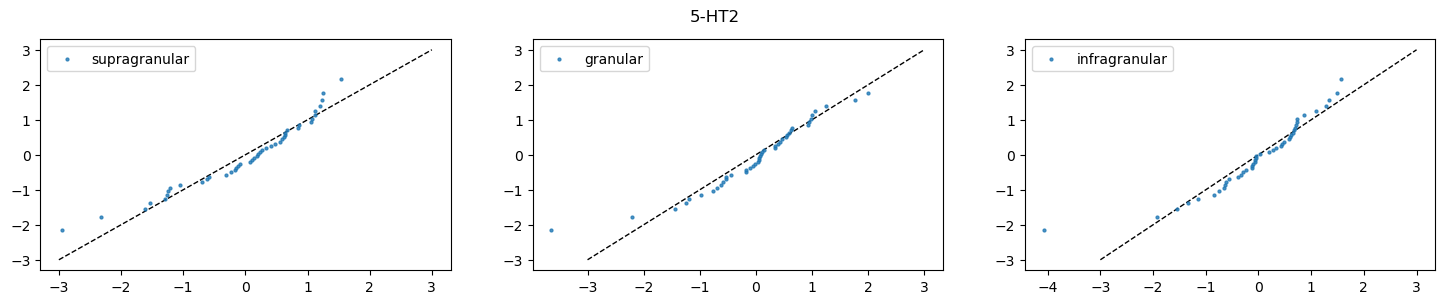

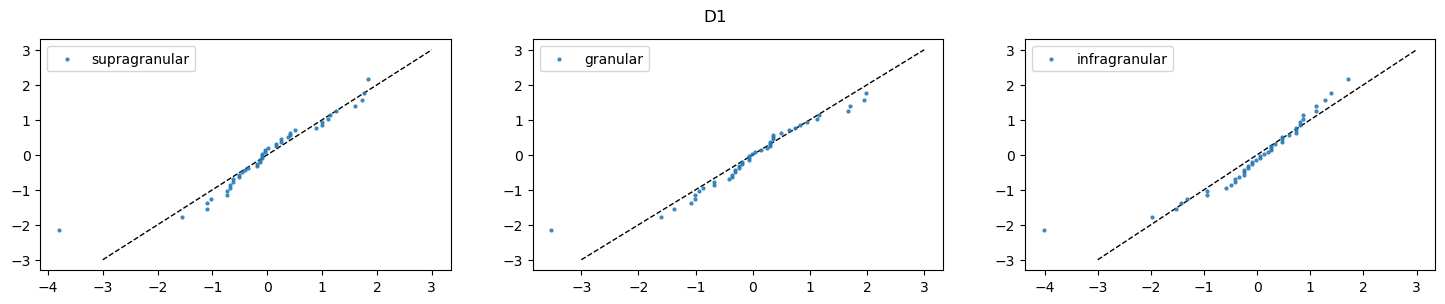

In [11]:
# Probplot
x = np.arange(-3, 3.1, step=0.1)

for rec in receptor_list:
    plt.figure(figsize=[18,3])
    aux = 0
    for l in layer:
        aux+=1
        plt.subplot(1,3,aux)
        plt.plot(x, x, '--', c='k', lw=linewidth, zorder=-10)
        
        logdata = np.log(data[rec][l].values)
        dist = (logdata - np.nanmean(logdata))/np.nanstd(logdata)
        (Q, P), _ = stats.probplot(dist)
        plt.scatter(P, Q, alpha=sample_alpha, s=20,
                   marker='.', linewidth=0.8, label=l)
        plt.legend()
    plt.suptitle(rec)

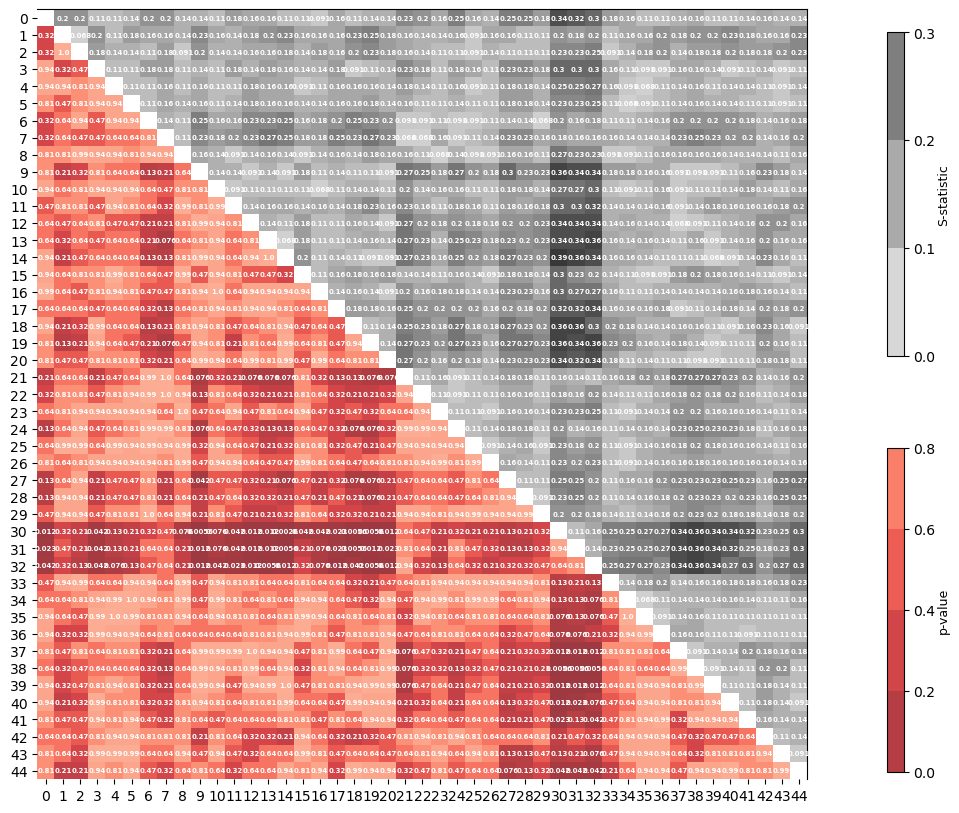

In [12]:
# Get pairwise KS two sample test
Ds = np.empty((len(zs),len(zs)))
Ds[:] = np.nan
ps = np.empty((len(zs),len(zs)))
ps[:] = np.nan
for i, z0 in enumerate(zs):
    for j, z1 in enumerate(zs):
        D, z = D, p = stats.ks_2samp(z0, z1)
        Ds[i, j] = D        
        ps[i, j] = p
Ds[np.tril_indices(len(zs))] = np.nan
ps[np.triu_indices(len(zs))] = np.nan

# Plot two sample test results
fig, ax = plt.subplots(1, figsize=(10.0, 10.0))
p_im = ax.imshow(ps, cmap='Reds_r', norm=Normalize(-0.1, 1.6), alpha=0.8)
D_im = ax.imshow(Ds, cmap='Greys', norm=Normalize(-0.1, 0.4), alpha=0.8)
fs = 5
for i in range(len(zs)):
    for j in range(len(zs)):
        if Ds[i, j] == Ds[i, j]:
            ax.text(j, i, f'{Ds[i,j]:.2}', color='w', ha='center', va='center', fontweight='bold', fontsize=fs)
        if ps[i, j] == ps[i, j]:
            ax.text(j, i, f'{ps[i,j]:.2}', color='w', ha='center', va='center', fontweight='bold', fontsize=fs)

ax.set_xticks(range(len(zs)))
ax.set_yticks(range(len(zs)))
# ax.set_xticklabels(receptor_list, rotation=90, ha='center', va='top', fontsize=7)
# ax.set_yticklabels(receptor_list, fontsize=7)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

axin1 = ax.inset_axes([1.1, 0.01,   0.05, 0.42])
axin2 = ax.inset_axes([1.1, 0.55, 0.05, 0.42])
axin1.axis('off')
axin2.axis('off')
cb = plt.colorbar(p_im, ax=axin1, fraction=1, pad=0, boundaries=np.arange(0, 1, step=0.2))
cb.set_label(label='p-value', fontsize=9, labelpad=1)
cb = plt.colorbar(D_im, ax=axin2, fraction=1, pad=0, boundaries=[0, 0.1, 0.2, 0.3])
cb.set_label(label='S-statistic', fontsize=9, labelpad=1)